# Trajectory Optimization of a Pneumatic Cylinder
## Mass Modelling

In [92]:
# Import Optimization Libraries
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition

# Import General Libraries
import sympy as sym
import numpy as np
from IPython.display import display 

# Create a Concrete Model
model = ConcreteModel()

In [93]:
Nodes = 100
model.Nodes = range(Nodes)

In [94]:
model.X0 = Param(initialize = 0.0) # position of fixed base
model.Y0 = Param(initialize = 0.0)
model.h = Param(initialize = 0.02) # time step

model.mass = Param(initialize = 1.0) # mass of the 'mass'

# Initailize Position, Velocity and Acceleration
model.x1 = Var(model.Nodes)
model.dx1 = Var(model.Nodes)
model.ddx1 = Var(model.Nodes)

model.Force = Var(model.Nodes)

In [95]:
# Intergration Constraints
def BwEuler_p(model,n): # Positions
    if n > 1:
        return model.x1[n] == model.x1[n-1] + model.h*model.dx1[n-1]
    else:
        return Constraint.Skip # Leaves out members of a set that the constraint doesn't apply to
model.integrate_p = Constraint(model.Nodes, rule = BwEuler_p)

def BwEuler_v(model,n): # Velocities
    if n > 1:
        return model.dx1[n] == model.dx1[n-1] + model.h*model.ddx1[n-1]
    else:
        return Constraint.Skip 
model.integrate_v = Constraint(model.Nodes, rule = BwEuler_v)

In [96]:
X0 = sym.symbols('X0')   #starting position of the block
m1 = sym.symbols('m1')   #mass of the block

x1 = sym.symbols('x1')                #position of the block
dx1 = sym.symbols('\dot{\\ x}_{1}')    #velocity of the block
ddx1 = sym.symbols('\ddot{\\ x}_{1}')  #acceleration of the block

q = sym.Matrix([x1])
dq = sym.Matrix([dx1])
ddq = sym.Matrix([ddx1])

Xnew = X0 + x1

p1 = sym.Matrix([Xnew, x1])
[dXnew, dx1] = p1.jacobian(q)*dq
display(p1)             # [original position + current position ; current position]

# Just checking
dp1 = sym.Matrix([dXnew, dx1]) # --> derivative of the p1 matrix
display(dp1)

######################################################################################################################
######################################################################################################################

#Define kinetic and potential energies for use in Lagrangian
T = sym.Matrix([0.5*m1*(dXnew**2)])
V = sym.Matrix([0]) 

#Calculate terms of the Lagrangian Equation
Lg1 = sym.zeros(1,len(q))
for i in range(len(q)):
    dT_ddq = sym.diff(T,dq[i]) 
    Lg1[i] = dT_ddq.jacobian(q)*dq + dT_ddq.jacobian(dq)*ddq 

Lg3 = T.jacobian(q)

Lg4 = V.jacobian(q) 

#apply a horizontal force
F = sym.symbols('F')                  #applied force parameter
FF = sym.Matrix([[F],[0],[0]])        #force matrix
rF = sym.Matrix([[X0 + Xnew],[0],[0]])  #distance the force acts on the block
JF = rF.jacobian(q)
QF = JF.transpose()*FF
#display(QF)
Qall = QF
#Equation of motion
EOM = Lg1 - Lg3 + Lg4 - Qall.transpose() 
display(EOM)

Matrix([
[X0 + x1],
[     x1]])

Matrix([
[\dot{ x}_{1}],
[\dot{ x}_{1}]])

Matrix([[-F + 1.0*\ddot{ x}_{1}*m1]])

In [97]:
# Lambdify the EOM
func_map = {'sin':sin, 'cos':cos}  
sym_list = [X0, x1, dx1, ddx1, F, m1]

lambEOM1 = sym.lambdify(sym_list, EOM[0], modules = [func_map])

#display(lambEOM1)

# Create EOM Constraints
def EOM1(model,n): 
    # list the model versions of all quantities in the same order as sym_list
    var_list = [model.X0, model.x1[n], model.dx1[n], model.ddx1[n], model.Force[n], model.mass] 
    return lambEOM1(*var_list) == 0
model.EOM = Constraint(model.Nodes, rule = EOM1)

In [98]:
# Define Cost Function
def CostFunction(model):
    sum_force = 0
    for n in range(1,Nodes):
            sum_force = sum_force + model.Force[n]**2 
    return sum_force

model.Cost = Objective(rule = CostFunction)  

In [99]:
# Define Variable Bounds
for n in range(1,Nodes):
    model.Force[n].setlb(-40)
    model.Force[n].setub(40)
    model.x1[n].setlb(-50)
    model.x1[n].setub(50)

In [100]:
# Initialization of variables
for n in range (1,Nodes):
    model.Force[n].value = 5
    
    model.x1[n].value = np.random.uniform(-20,20)
    model.dx1[n].value = 30
    model.ddx1[n].value = 30

In [101]:
# Set Boundary Conditions
# Initial Conditions
model.x1[1].fixed = True
model.x1[1].value = 0

model.dx1[1].fixed = True
model.dx1[1].value = 0

# Final Conditions
# Nodes-1 ensures it stops at 99, if you just say Nodes jupyter throughs a tantrum
model.x1[Nodes-1].fixed = True 
model.x1[Nodes-1].value = 2   # Stop at specified location in m

model.dx1[Nodes-1].fixed = True
model.dx1[Nodes-1].value = 0

In [102]:
# Start the Solver
optimize = SolverFactory('ipopt')

optimize.options["print_level"] = 5
optimize.options["max_iter"] = 30000
optimize.options["max_cpu_time"] = 300
optimize.options["Tol"] = 1e-6

results = optimize.solve(model, tee = True)

Ipopt 3.11.1: print_level=5
max_iter=30000
max_cpu_time=300
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:      783
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       99

Total number of variables............................:      394
                     variables with only lower bounds:        0
        

In [103]:
# Some debugging stuff
print(results.solver.status) # tells you if the solver had any errors/ warnings
print(results.solver.termination_condition) # tells you if the solution was (locally) optimal, feasible, or neither.

ok
optimal


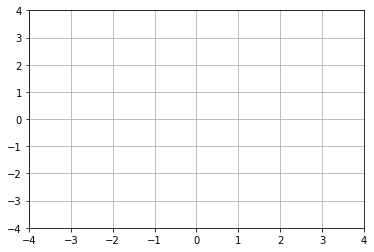

In [104]:
#animate model --> will be able to see what model is doing by viewing in with HTML
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
%matplotlib inline

fig1, ax1 = plt.subplots(1,1)
def plot_block(i,model,ax): #update function for animation
    ax.clear()
    ax.set_xlim([-4,4])
    ax.set_ylim([-4,4])
    
    #plot mass
    m1topx = model.X0.value   #initial position of mass
    m1bottomx = m1topx + model.x1[i].value
    ax.plot([m1bottomx,0],[m1topx,0],color = 'xkcd:red')
  # ax.plot([m1topx,0],color = 'xkcd:red')  #plot initial block
    ax.grid(True)
    
update = lambda i: plot_block(i,model,ax1)      #lambdify just used to calculate the numerical values fast

animate = ani.FuncAnimation(fig1,update,range(1,Nodes),interval = 50, repeat = True)

#animate.save('show_me_the_money.gif', writer = 'ffmpeg')

HTML(animate.to_html5_video()) 